In [1]:
import random
import math
from operator import add
import numpy as np
import time
import findspark
import matplotlib.pyplot as plt
from pyspark import SparkContext

In [2]:
findspark.init()
sc = SparkContext("local[*]", "CrossValidation")

24/02/15 10:49:33 WARN Utils: Your hostname, vm resolves to a loopback address: 127.0.1.1; using 10.0.2.15 instead (on interface enp0s3)
24/02/15 10:49:33 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


24/02/15 10:49:44 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Declaración de funciones

In [3]:
def readFile(path, cols=np.inf):
    # Inicializar una sesión de Spark
    rdd = sc.textFile(path)
    rdd.cache()
    rdd.count()
    # Leer el archivo como un RDD de líneas
    def parse_line(rdd):
        # Dividir la línea por comas
        parts = rdd.split(',')
        # Convertir las partes en números y extraer solo las columnas necesarias
        cols_to_take = min(cols, len(parts) - 1)
        x = [float(x) for x in parts[:cols_to_take]]
        y = float(parts[-1])
        return (x, y)

    # Aplicar la función de parseo a cada línea
    parsed_data = rdd.map(parse_line)

    numpy_data = parsed_data.map(lambda x: (np.array(x[0], dtype=float), x[1]))

    # Convertir los datos en un arreglo numpy y retornarlo
    return numpy_data

In [4]:
def normalize(X_y):
    X = X_y.map(lambda x: x[0])
    y = X_y.map(lambda x: x[1])

    m = X.count()
    n = len(X.reduce(lambda x, y: x + y))
    
    col_sum = X.map(lambda x: np.array(x)).reduce(lambda x, y: np.add(x, y))
    sum_squares_col = X.map(lambda x: np.array(x**2)).reduce(lambda x, y: np.add(x, y))

    means = col_sum / m
    print(f"Means: {means}\n")
    
    var = ((sum_squares_col / m) - (means**2))
    std = var**0.5
    print(f"Std: {std}\n")
    
    normalized_rdd = X_y.map(lambda x: (np.array((x[0] - means) / std, dtype=object), x[1]))
    
    return normalized_rdd

In [5]:
def get_y_hat (x,w):
    #print (x.shape, w.shape)
    return sigmoid(get_dot_xw(x,w))

def get_dot_xw(x,w):
    
    r = 0.
    if (len(x)>=len(w)):
        #print ("getdot",len(x),len(w))
        pass
    for i in range(len(x)):
        r += float(x[i])*float(w[i])
    return r + w[-1]

def sigmoid(x):
    try:
        return 1. / (1.+math.exp(-x))
    except OverflowError:
        return 0.0

In [6]:
def predict (x,w):
    threshold=0.5
    y_hat=get_y_hat(x,w)
    return 1 if y_hat > threshold else 0
        
# Check the accuracy of the model
def accuracy(X_y, wf):
    #compute the number of correct answers for each element of the dataset 
    correct_answers=0
    
    def count_correct(x_y):
        x, y = x_y
        return 1 if predict(x, wf) == y else 0
    
    correct_answers = X_y.map(count_correct).reduce(lambda x, y: x + y)
    accuracy = correct_answers*100.0/X_y.count()

    return accuracy

In [7]:
# Update model weights using current weights, their derivatives and the learning rate 
def update_ws(w,dw,lr):
    w_ = np.array(w, dtype=float)
    dw_ = np.array(dw, dtype=float)
    #print ("shapes w y dw",w.shape,dw.shape)
    tmp = w_ - lr*dw_
    neww = tmp    
    return neww

# Get derivatives of Cost function for each element of the dataset
def get_derivatives(x_y, w): 
    x = np.array(x_y[0], dtype=float)
    y= x_y[1]
    diff_y = get_y_hat(x,w) - y
    # Vectorized version
    # res = list(x*diff_y)+ [w[-1]]
    res=[]
    # dw
    for x_i in x:
        res.append(x_i*diff_y)
    # db
    res.append(diff_y)
    return res
    

In [8]:
# Cost function   
def fcost(y, y_hat):
    #print ("cost:",y,y_hat)
    # compute loss/cost for one element "y_hat" and one label "y" 
    epsilon=0.00000001
    if y == 1:
        return -np.log(y_hat if y_hat > 0. else epsilon)
    else:
        return -np.log (1-y_hat if 1-y_hat >0. else epsilon)
                 

In [9]:
def transform(data):
    data = data.map(lambda x: (random.randint(0, 9), x))

    return data

def get_block_data(data_cv, key):
    
    test_data = data_cv.flatMap(lambda x: [x] if x[0] == key else []).map(lambda x: x[1])
    tr_data = data_cv.flatMap(lambda x: [x] if x[0] != key else []).map(lambda x: x[1])
    
    return tr_data, test_data

In [10]:
def train(X_y, iterations, learning_rate, print_it=True):
    X_y.cache()
    m = X_y.count()

    num_columns = len(X_y.take(1)[0][0])

    w = np.array([random.uniform(0.0, 1.0) for _ in range(num_columns + 1)])

    for iterac in range(iterations):
        y_hat_rdd = X_y.map(lambda x: (x[1],np.array(get_y_hat(x[0], w))))
        cost = y_hat_rdd.map(lambda x: np.array(fcost(x[0], x[1]))).reduce(lambda x, y: np.add(x, y)) / m
        
        if print_it:
            print("iteration", iterac, "Cost:", cost)

        dw_tot_rdd = X_y.map(lambda x: np.array(get_derivatives(x, w))).reduce(lambda x, y: np.add(x, y))
        dw_tot_rdd /= m
        w = update_ws(w, dw_tot_rdd, learning_rate)
        
    return w

# Prueba

In [11]:
def test_cv(path, nIter=10, learningRate=1.5, num_blocks_cv=10, print_it=True):
    avg_acc = 0
    total_time = 0
    
    # read text_file in dataPath
    X_y = readFile(path)

    #Normalize
    X_y = normalize(X_y)

    #Transform data
    data_cv = transform(X_y)
    
    
    for i in range(num_blocks_cv):
        print(f"Block {i}")
        tr_data, test_data = get_block_data(data_cv, i)
        t1 = time.time()
        ws = train(tr_data, nIter, learningRate, print_it)
        t2 = time.time()
        block_time = t2-t1
        acc = accuracy(test_data, ws)

        print ("Accuracy of the model:",acc,"%")
        print (f"Time for block {i}: {block_time}")
        avg_acc += acc
        total_time += block_time
    
    avg_acc /= num_blocks_cv
    
    print ("Average accuracy:",avg_acc,"%")
    print ("Total time:",total_time,"s")
    
    return total_time, avg_acc

In [12]:
#EXERCISE 3: CROSS-VALIDATION

#Execution parameters
path = "./botnet_reduced_l.csv"

_, _ = test_cv(path)

Means: [1.27838919e+03 2.13364895e+04 6.93013712e+03 6.25819129e+04
 1.22276971e+08 1.57460545e+07 9.11132215e+00 1.89416481e+00
 1.24196646e+02 2.12980313e+09 2.25738831e+09]

Std: [1.60563017e+03 2.41267530e+04 1.63668384e+04 1.34535232e+05
 2.34005376e+08 4.41865109e+07 5.28106132e+00 2.10223611e+00
 9.03451248e+01 7.14764695e+08 1.30262025e+09]

Block 0


iteration 0 Cost: 1.5060585642603517


iteration 1 Cost: 0.8183354323386111


iteration 2 Cost: 0.5178624545718297


iteration 3 Cost: 0.3830399762567383


iteration 4 Cost: 0.3173423890561711


iteration 5 Cost: 0.2813374743424859


iteration 6 Cost: 0.25887083496313695


iteration 7 Cost: 0.2434227653925977


iteration 8 Cost: 0.23207255692657558


iteration 9 Cost: 0.22333930211445957


Accuracy of the model: 92.60634453886217 %
Time for block 0: 27.74043369293213
Block 1


24/02/15 10:50:27 WARN BlockManager: Task 125 already completed, not releasing lock for rdd_63_0


iteration 0 Cost: 1.3206158266295205


iteration 1 Cost: 0.7648848592195148


iteration 2 Cost: 0.5003512175642617


iteration 3 Cost: 0.3722183118478834


iteration 4 Cost: 0.307430627591496


iteration 5 Cost: 0.27176212060377003


iteration 6 Cost: 0.24988363455769638


iteration 7 Cost: 0.23519557336300073


iteration 8 Cost: 0.22465022055062409


iteration 9 Cost: 0.2166934991574914


Accuracy of the model: 92.33853788125612 %
Time for block 1: 25.288150310516357
Block 2


iteration 0 Cost: 1.4464315798204126


iteration 1 Cost: 0.7603463842953176


iteration 2 Cost: 0.4694252104353493


iteration 3 Cost: 0.3541590167283864


iteration 4 Cost: 0.29955477855430934


iteration 5 Cost: 0.2685231158426278


iteration 6 Cost: 0.24862059649001028


iteration 7 Cost: 0.23477809042075062


iteration 8 Cost: 0.22458706934525535


iteration 9 Cost: 0.21676417198097733


Accuracy of the model: 92.4693913173578 %
Time for block 2: 25.2748920917511
Block 3


24/02/15 10:51:22 WARN BlockManager: Task 319 already completed, not releasing lock for rdd_175_0


iteration 0 Cost: 1.1846099522093254


iteration 1 Cost: 0.616067991365848


iteration 2 Cost: 0.4120094232985178


iteration 3 Cost: 0.3311069316575519


iteration 4 Cost: 0.28886274148126295


iteration 5 Cost: 0.2628813141518106


iteration 6 Cost: 0.24530174409103625


iteration 7 Cost: 0.232636704026774


iteration 8 Cost: 0.2230934277844938


iteration 9 Cost: 0.21565386718008944


Accuracy of the model: 92.97016274864376 %
Time for block 3: 25.770931482315063
Block 4


24/02/15 10:51:50 WARN BlockManager: Task 416 already completed, not releasing lock for rdd_231_0


iteration 0 Cost: 1.1987106473051643


iteration 1 Cost: 0.6389895597537224


iteration 2 Cost: 0.4243627307959051


iteration 3 Cost: 0.3397573683146913


iteration 4 Cost: 0.2963416911364537


iteration 5 Cost: 0.26984897086839155


iteration 6 Cost: 0.251944139279878


iteration 7 Cost: 0.23900593343373402


iteration 8 Cost: 0.22920135538712755


iteration 9 Cost: 0.22150149538129202


Accuracy of the model: 93.82784669412092 %
Time for block 4: 25.59841561317444
Block 5


24/02/15 10:52:18 WARN BlockManager: Task 513 already completed, not releasing lock for rdd_287_0


iteration 0 Cost: 1.1419212465531061


iteration 1 Cost: 0.5630183385172063


iteration 2 Cost: 0.38677304157495035


iteration 3 Cost: 0.3187237986401305


iteration 4 Cost: 0.28322833547368675


iteration 5 Cost: 0.26114120581607964


iteration 6 Cost: 0.245885474441366


iteration 7 Cost: 0.23462107137152968


iteration 8 Cost: 0.22591372963627276


iteration 9 Cost: 0.2189551099717087


Accuracy of the model: 92.9978063615515 %
Time for block 5: 26.832090377807617
Block 6


24/02/15 10:52:47 WARN BlockManager: Task 610 already completed, not releasing lock for rdd_343_0


iteration 0 Cost: 1.0599528472902056


iteration 1 Cost: 0.5973086329094123


iteration 2 Cost: 0.4252618469872714


iteration 3 Cost: 0.34351794154258886


iteration 4 Cost: 0.2991576549306889


iteration 5 Cost: 0.2720669008068826


iteration 6 Cost: 0.25387017801364864


iteration 7 Cost: 0.2407648036567022


iteration 8 Cost: 0.23083447380128755


iteration 9 Cost: 0.2230199425572522


Accuracy of the model: 93.29635459610724 %
Time for block 6: 26.718225955963135
Block 7


iteration 0 Cost: 1.1386039045305485


iteration 1 Cost: 0.5654864028483532


iteration 2 Cost: 0.37623067382780523


iteration 3 Cost: 0.3090693792698208


iteration 4 Cost: 0.2750362643599329


iteration 5 Cost: 0.25402365324853327


iteration 6 Cost: 0.23958601334818813


iteration 7 Cost: 0.2289839891667206


iteration 8 Cost: 0.22083545718660916


iteration 9 Cost: 0.21435973978660175


Accuracy of the model: 93.53291599353797 %
Time for block 7: 26.08924698829651
Block 8


24/02/15 10:53:44 WARN BlockManager: Task 804 already completed, not releasing lock for rdd_455_0


iteration 0 Cost: 1.0169780811240103


iteration 1 Cost: 0.5192306171565377


iteration 2 Cost: 0.3768860101447361


iteration 3 Cost: 0.3167907415764305


iteration 4 Cost: 0.28344916289919947


iteration 5 Cost: 0.2619546727362848


iteration 6 Cost: 0.2468021728248604


iteration 7 Cost: 0.23547843715670944


iteration 8 Cost: 0.22666192639708801


iteration 9 Cost: 0.2195856823842865


Accuracy of the model: 92.08808122936372 %
Time for block 8: 25.986318349838257
Block 9


iteration 0 Cost: 1.0916492732240084


iteration 1 Cost: 0.5876998869016037


iteration 2 Cost: 0.40394021411435393


iteration 3 Cost: 0.32549513796482527


iteration 4 Cost: 0.2849687226836305


iteration 5 Cost: 0.26058485448278035


iteration 6 Cost: 0.24428736759446304


iteration 7 Cost: 0.23257706565483663


iteration 8 Cost: 0.22371709164753653


iteration 9 Cost: 0.21675263183055637


Accuracy of the model: 93.05116232364311 %
Time for block 9: 25.79383683204651
Average accuracy: 92.91786036844442 %
Total time: 261.0925416946411 s


# Gráficas

In [13]:
num_workers = list(range(1, 9))
tiempos_ejecucion_cv = []

for i in num_workers:
    print(f"Test with {i} core/s")
    sc.stop()
    sc = SparkContext(f"local[{i}]", "CrossValidation")
    total_time, _ = test_cv(path, print_it=False)
    tiempos_ejecucion_cv.append(total_time)

Test with 1 core/s


Means: [1.27838919e+03 2.13364895e+04 6.93013712e+03 6.25819129e+04
 1.22276971e+08 1.57460545e+07 9.11132215e+00 1.89416481e+00
 1.24196646e+02 2.12980313e+09 2.25738831e+09]

Std: [1.60563017e+03 2.41267530e+04 1.63668384e+04 1.34535232e+05
 2.34005376e+08 4.41865109e+07 5.28106132e+00 2.10223611e+00
 9.03451248e+01 7.14764695e+08 1.30262025e+09]

Block 0


24/02/15 10:54:57 WARN BlockManager: Task 28 already completed, not releasing lock for rdd_7_0


Accuracy of the model: 91.89189189189189 %
Time for block 0: 54.320456743240356
Block 1


24/02/15 10:55:58 WARN BlockManager: Task 125 already completed, not releasing lock for rdd_63_0


Accuracy of the model: 92.50911998400879 %
Time for block 1: 54.711886405944824
Block 2


24/02/15 10:56:59 WARN BlockManager: Task 222 already completed, not releasing lock for rdd_119_0


Accuracy of the model: 93.40959150981178 %
Time for block 2: 57.212557792663574
Block 3


24/02/15 10:58:03 WARN BlockManager: Task 319 already completed, not releasing lock for rdd_175_0


Accuracy of the model: 93.35207873066881 %
Time for block 3: 56.139418601989746
Block 4


Accuracy of the model: 93.46954123840561 %
Time for block 4: 63.03598093986511
Block 5


24/02/15 11:00:17 WARN BlockManager: Task 513 already completed, not releasing lock for rdd_287_0


Accuracy of the model: 92.86001003512293 %
Time for block 5: 62.283493757247925
Block 6


Accuracy of the model: 93.18534461184244 %
Time for block 6: 60.55998611450195
Block 7


24/02/15 11:02:34 WARN BlockManager: Task 707 already completed, not releasing lock for rdd_399_0


Accuracy of the model: 93.08543868855736 %
Time for block 7: 57.963295698165894
Block 8


24/02/15 11:03:39 WARN BlockManager: Task 804 already completed, not releasing lock for rdd_455_0


Accuracy of the model: 93.22286537649367 %
Time for block 8: 58.35130572319031
Block 9


24/02/15 11:04:44 WARN BlockManager: Task 901 already completed, not releasing lock for rdd_511_0


Accuracy of the model: 93.20410093067237 %
Time for block 9: 56.841938972473145
Average accuracy: 93.01899829974755 %
Total time: 581.4203207492828 s
Test with 2 core/s


Means: [1.27838919e+03 2.13364895e+04 6.93013712e+03 6.25819129e+04
 1.22276971e+08 1.57460545e+07 9.11132215e+00 1.89416481e+00
 1.24196646e+02 2.12980313e+09 2.25738831e+09]

Std: [1.60563017e+03 2.41267530e+04 1.63668384e+04 1.34535232e+05
 2.34005376e+08 4.41865109e+07 5.28106132e+00 2.10223611e+00
 9.03451248e+01 7.14764695e+08 1.30262025e+09]

Block 0


24/02/15 11:05:54 WARN BlockManager: Task 28 already completed, not releasing lock for rdd_7_0


Accuracy of the model: 93.11221945137157 %
Time for block 0: 36.00295281410217
Block 1


24/02/15 11:06:34 WARN BlockManager: Task 125 already completed, not releasing lock for rdd_63_0


Accuracy of the model: 93.38277812696417 %
Time for block 1: 35.14899730682373
Block 2


24/02/15 11:07:13 WARN BlockManager: Task 222 already completed, not releasing lock for rdd_119_0


Accuracy of the model: 92.30576063482498 %
Time for block 2: 35.558818101882935
Block 3


24/02/15 11:07:53 WARN BlockManager: Task 319 already completed, not releasing lock for rdd_175_0


Accuracy of the model: 92.81596230009525 %
Time for block 3: 35.552330493927
Block 4


24/02/15 11:08:32 WARN BlockManager: Task 416 already completed, not releasing lock for rdd_231_0


Accuracy of the model: 92.53694151653335 %
Time for block 4: 36.08882188796997
Block 5


24/02/15 11:09:13 WARN BlockManager: Task 513 already completed, not releasing lock for rdd_287_0


Accuracy of the model: 92.57961145603845 %
Time for block 5: 36.02391695976257
Block 6


24/02/15 11:09:53 WARN BlockManager: Task 610 already completed, not releasing lock for rdd_343_0


Accuracy of the model: 93.43360787464846 %
Time for block 6: 36.82913637161255
Block 7


Accuracy of the model: 93.21496831304698 %
Time for block 7: 37.306580543518066
Block 8


24/02/15 11:11:15 WARN BlockManager: Task 804 already completed, not releasing lock for rdd_455_0


Accuracy of the model: 92.28485912880006 %
Time for block 8: 36.73658561706543
Block 9


24/02/15 11:11:56 WARN BlockManager: Task 901 already completed, not releasing lock for rdd_511_0


Accuracy of the model: 91.19493745983092 %
Time for block 9: 36.79313659667969
Average accuracy: 92.68616462621542 %
Total time: 362.0412766933441 s
Test with 3 core/s


Means: [1.27838919e+03 2.13364895e+04 6.93013712e+03 6.25819129e+04
 1.22276971e+08 1.57460545e+07 9.11132215e+00 1.89416481e+00
 1.24196646e+02 2.12980313e+09 2.25738831e+09]

Std: [1.60563017e+03 2.41267530e+04 1.63668384e+04 1.34535232e+05
 2.34005376e+08 4.41865109e+07 5.28106132e+00 2.10223611e+00
 9.03451248e+01 7.14764695e+08 1.30262025e+09]

Block 0


24/02/15 11:12:43 WARN BlockManager: Task 28 already completed, not releasing lock for rdd_7_0


Accuracy of the model: 94.32339738740102 %
Time for block 0: 29.261452436447144
Block 1


24/02/15 11:13:14 WARN BlockManager: Task 125 already completed, not releasing lock for rdd_63_0


Accuracy of the model: 93.2991504549339 %
Time for block 1: 28.609909296035767
Block 2


Accuracy of the model: 93.76661150393662 %
Time for block 2: 28.365260362625122
Block 3


24/02/15 11:14:17 WARN BlockManager: Task 319 already completed, not releasing lock for rdd_175_0


Accuracy of the model: 93.47210741213897 %
Time for block 3: 28.441220998764038
Block 4


24/02/15 11:14:48 WARN BlockManager: Task 416 already completed, not releasing lock for rdd_231_0


Accuracy of the model: 93.78605859287195 %
Time for block 4: 28.991633415222168
Block 5


24/02/15 11:15:20 WARN BlockManager: Task 513 already completed, not releasing lock for rdd_287_0


Accuracy of the model: 92.8276380022531 %
Time for block 5: 28.348807334899902
Block 6


24/02/15 11:15:51 WARN BlockManager: Task 610 already completed, not releasing lock for rdd_343_0


Accuracy of the model: 92.28931255911195 %
Time for block 6: 29.100457191467285
Block 7


24/02/15 11:16:23 WARN BlockManager: Task 707 already completed, not releasing lock for rdd_399_0


Accuracy of the model: 93.99164185080454 %
Time for block 7: 30.274606466293335
Block 8


24/02/15 11:16:56 WARN BlockManager: Task 804 already completed, not releasing lock for rdd_455_0


Accuracy of the model: 92.73953778888195 %
Time for block 8: 29.991779327392578
Block 9


24/02/15 11:17:29 WARN BlockManager: Task 901 already completed, not releasing lock for rdd_511_0


Accuracy of the model: 93.63479478778481 %
Time for block 9: 29.841899871826172
Average accuracy: 93.41302503401188 %
Total time: 291.2270267009735 s
Test with 4 core/s


Means: [1.27838919e+03 2.13364895e+04 6.93013712e+03 6.25819129e+04
 1.22276971e+08 1.57460545e+07 9.11132215e+00 1.89416481e+00
 1.24196646e+02 2.12980313e+09 2.25738831e+09]

Std: [1.60563017e+03 2.41267530e+04 1.63668384e+04 1.34535232e+05
 2.34005376e+08 4.41865109e+07 5.28106132e+00 2.10223611e+00
 9.03451248e+01 7.14764695e+08 1.30262025e+09]

Block 0


24/02/15 11:18:07 WARN BlockManager: Task 28 already completed, not releasing lock for rdd_7_0


Accuracy of the model: 92.85286932243108 %
Time for block 0: 29.131752490997314
Block 1


24/02/15 11:18:39 WARN BlockManager: Task 125 already completed, not releasing lock for rdd_63_0


Accuracy of the model: 93.48391615388464 %
Time for block 1: 28.833341360092163
Block 2


24/02/15 11:19:10 WARN BlockManager: Task 222 already completed, not releasing lock for rdd_119_0


Accuracy of the model: 92.94200035014882 %
Time for block 2: 28.32732343673706
Block 3


24/02/15 11:19:41 WARN BlockManager: Task 319 already completed, not releasing lock for rdd_175_0


Accuracy of the model: 92.89139987445073 %
Time for block 3: 29.186718463897705
Block 4


24/02/15 11:20:12 WARN BlockManager: Task 416 already completed, not releasing lock for rdd_231_0


Accuracy of the model: 92.38698460009935 %
Time for block 4: 27.222757816314697
Block 5


24/02/15 11:20:42 WARN BlockManager: Task 513 already completed, not releasing lock for rdd_287_0


Accuracy of the model: 92.62506575816028 %
Time for block 5: 28.012690544128418
Block 6


24/02/15 11:21:13 WARN BlockManager: Task 610 already completed, not releasing lock for rdd_343_0


Accuracy of the model: 92.30308774380207 %
Time for block 6: 28.017245054244995
Block 7


24/02/15 11:21:43 WARN BlockManager: Task 707 already completed, not releasing lock for rdd_399_0


Accuracy of the model: 93.02203436460496 %
Time for block 7: 27.136036157608032
Block 8


24/02/15 11:22:12 WARN BlockManager: Task 804 already completed, not releasing lock for rdd_455_0


Accuracy of the model: 92.89479601269143 %
Time for block 8: 25.581026077270508
Block 9


24/02/15 11:22:40 WARN BlockManager: Task 901 already completed, not releasing lock for rdd_511_0


Accuracy of the model: 91.91695673794132 %
Time for block 9: 26.54500436782837
Average accuracy: 92.73191109182147 %
Total time: 277.99389576911926 s
Test with 5 core/s


Means: [1.27838919e+03 2.13364895e+04 6.93013712e+03 6.25819129e+04
 1.22276971e+08 1.57460545e+07 9.11132215e+00 1.89416481e+00
 1.24196646e+02 2.12980313e+09 2.25738831e+09]

Std: [1.60563017e+03 2.41267530e+04 1.63668384e+04 1.34535232e+05
 2.34005376e+08 4.41865109e+07 5.28106132e+00 2.10223611e+00
 9.03451248e+01 7.14764695e+08 1.30262025e+09]

Block 0


24/02/15 11:23:14 WARN BlockManager: Task 28 already completed, not releasing lock for rdd_7_0


Accuracy of the model: 93.41848234410217 %
Time for block 0: 26.17509961128235
Block 1


24/02/15 11:23:43 WARN BlockManager: Task 125 already completed, not releasing lock for rdd_63_0


Accuracy of the model: 93.64006432807318 %
Time for block 1: 25.452704906463623
Block 2


24/02/15 11:24:10 WARN BlockManager: Task 222 already completed, not releasing lock for rdd_119_0


Accuracy of the model: 91.89905047476262 %
Time for block 2: 25.298240661621094
Block 3


24/02/15 11:24:38 WARN BlockManager: Task 319 already completed, not releasing lock for rdd_175_0


Accuracy of the model: 92.81441621824553 %
Time for block 3: 29.61582088470459
Block 4


24/02/15 11:25:11 WARN BlockManager: Task 416 already completed, not releasing lock for rdd_231_0


Accuracy of the model: 92.59648070385923 %
Time for block 4: 29.467357873916626
Block 5


24/02/15 11:25:42 WARN BlockManager: Task 513 already completed, not releasing lock for rdd_287_0


Accuracy of the model: 93.36879343653561 %
Time for block 5: 26.564594507217407
Block 6


24/02/15 11:26:11 WARN BlockManager: Task 610 already completed, not releasing lock for rdd_343_0


Accuracy of the model: 93.2712685437481 %
Time for block 6: 26.580594062805176
Block 7


24/02/15 11:26:40 WARN BlockManager: Task 707 already completed, not releasing lock for rdd_399_0


Accuracy of the model: 94.22589946095023 %
Time for block 7: 26.825651168823242
Block 8


24/02/15 11:27:09 WARN BlockManager: Task 804 already completed, not releasing lock for rdd_455_0


Accuracy of the model: 91.38131669513976 %
Time for block 8: 27.872488021850586
Block 9


24/02/15 11:27:39 WARN BlockManager: Task 901 already completed, not releasing lock for rdd_511_0


Accuracy of the model: 93.60023961661342 %
Time for block 9: 27.025290727615356
Average accuracy: 93.02160118220297 %
Total time: 270.87784242630005 s
Test with 6 core/s


Means: [1.27838919e+03 2.13364895e+04 6.93013712e+03 6.25819129e+04
 1.22276971e+08 1.57460545e+07 9.11132215e+00 1.89416481e+00
 1.24196646e+02 2.12980313e+09 2.25738831e+09]

Std: [1.60563017e+03 2.41267530e+04 1.63668384e+04 1.34535232e+05
 2.34005376e+08 4.41865109e+07 5.28106132e+00 2.10223611e+00
 9.03451248e+01 7.14764695e+08 1.30262025e+09]

Block 0


24/02/15 11:28:15 WARN BlockManager: Task 28 already completed, not releasing lock for rdd_7_0


Accuracy of the model: 93.35420057593589 %
Time for block 0: 28.343528747558594
Block 1


24/02/15 11:28:46 WARN BlockManager: Task 125 already completed, not releasing lock for rdd_63_0


Accuracy of the model: 93.32513613209204 %
Time for block 1: 27.486712217330933
Block 2


24/02/15 11:29:16 WARN BlockManager: Task 222 already completed, not releasing lock for rdd_119_0


Accuracy of the model: 91.86014885146997 %
Time for block 2: 26.54121232032776
Block 3


24/02/15 11:29:44 WARN BlockManager: Task 319 already completed, not releasing lock for rdd_175_0


Accuracy of the model: 93.37183027868441 %
Time for block 3: 26.38233971595764
Block 4


Accuracy of the model: 92.78894221155768 %
Time for block 4: 25.833898067474365
Block 5


24/02/15 11:30:41 WARN BlockManager: Task 513 already completed, not releasing lock for rdd_287_0


Accuracy of the model: 92.55273785336243 %
Time for block 5: 25.86725926399231
Block 6


24/02/15 11:31:09 WARN BlockManager: Task 610 already completed, not releasing lock for rdd_343_0


Accuracy of the model: 93.72224313135115 %
Time for block 6: 26.336307764053345
Block 7


24/02/15 11:31:38 WARN BlockManager: Task 707 already completed, not releasing lock for rdd_399_0


Accuracy of the model: 92.95182832274523 %
Time for block 7: 26.4155855178833
Block 8


24/02/15 11:32:07 WARN BlockManager: Task 804 already completed, not releasing lock for rdd_455_0


Accuracy of the model: 92.7712639109698 %
Time for block 8: 26.79742455482483
Block 9


24/02/15 11:32:36 WARN BlockManager: Task 901 already completed, not releasing lock for rdd_511_0


Accuracy of the model: 92.09666558595406 %
Time for block 9: 25.811640977859497
Average accuracy: 92.87949968541226 %
Total time: 265.8159091472626 s
Test with 7 core/s


Means: [1.27838919e+03 2.13364895e+04 6.93013712e+03 6.25819129e+04
 1.22276971e+08 1.57460545e+07 9.11132215e+00 1.89416481e+00
 1.24196646e+02 2.12980313e+09 2.25738831e+09]

Std: [1.60563017e+03 2.41267530e+04 1.63668384e+04 1.34535232e+05
 2.34005376e+08 4.41865109e+07 5.28106132e+00 2.10223611e+00
 9.03451248e+01 7.14764695e+08 1.30262025e+09]

Block 0


24/02/15 11:33:09 WARN BlockManager: Task 28 already completed, not releasing lock for rdd_7_0


Accuracy of the model: 92.706300355302 %
Time for block 0: 25.714463472366333
Block 1


24/02/15 11:33:37 WARN BlockManager: Task 125 already completed, not releasing lock for rdd_63_0


Accuracy of the model: 93.0804907241173 %
Time for block 1: 26.22614073753357
Block 2


24/02/15 11:34:06 WARN BlockManager: Task 222 already completed, not releasing lock for rdd_119_0


Accuracy of the model: 92.25196066226815 %
Time for block 2: 25.769695520401
Block 3


24/02/15 11:34:34 WARN BlockManager: Task 319 already completed, not releasing lock for rdd_175_0


Accuracy of the model: 92.57988580586998 %
Time for block 3: 25.36649513244629
Block 4


24/02/15 11:35:01 WARN BlockManager: Task 416 already completed, not releasing lock for rdd_231_0


Accuracy of the model: 93.12363936641394 %
Time for block 4: 25.425721883773804
Block 5


24/02/15 11:35:29 WARN BlockManager: Task 513 already completed, not releasing lock for rdd_287_0


Accuracy of the model: 93.3472613773661 %
Time for block 5: 28.243178844451904
Block 6


24/02/15 11:36:00 WARN BlockManager: Task 610 already completed, not releasing lock for rdd_343_0


Accuracy of the model: 92.77042080757003 %
Time for block 6: 27.70921230316162
Block 7


24/02/15 11:36:30 WARN BlockManager: Task 707 already completed, not releasing lock for rdd_399_0


Accuracy of the model: 92.39257690870595 %
Time for block 7: 25.10713768005371
Block 8


24/02/15 11:36:57 WARN BlockManager: Task 804 already completed, not releasing lock for rdd_455_0


Accuracy of the model: 92.69490638011419 %
Time for block 8: 26.83847141265869
Block 9


24/02/15 11:37:26 WARN BlockManager: Task 901 already completed, not releasing lock for rdd_511_0


Accuracy of the model: 92.47648902821317 %
Time for block 9: 27.052045106887817
Average accuracy: 92.74239314159408 %
Total time: 263.45256209373474 s
Test with 8 core/s


Means: [1.27838919e+03 2.13364895e+04 6.93013712e+03 6.25819129e+04
 1.22276971e+08 1.57460545e+07 9.11132215e+00 1.89416481e+00
 1.24196646e+02 2.12980313e+09 2.25738831e+09]

Std: [1.60563017e+03 2.41267530e+04 1.63668384e+04 1.34535232e+05
 2.34005376e+08 4.41865109e+07 5.28106132e+00 2.10223611e+00
 9.03451248e+01 7.14764695e+08 1.30262025e+09]

Block 0


24/02/15 11:38:02 WARN BlockManager: Task 28 already completed, not releasing lock for rdd_7_0


Accuracy of the model: 92.29065020412227 %
Time for block 0: 26.787673711776733
Block 1


24/02/15 11:38:31 WARN BlockManager: Task 125 already completed, not releasing lock for rdd_63_0


Accuracy of the model: 93.96560394247209 %
Time for block 1: 25.858757257461548
Block 2


Accuracy of the model: 92.19807003581377 %
Time for block 2: 26.977378129959106
Block 3


24/02/15 11:39:28 WARN BlockManager: Task 319 already completed, not releasing lock for rdd_175_0


Accuracy of the model: 93.11759228969022 %
Time for block 3: 26.027353286743164
Block 4


24/02/15 11:39:57 WARN BlockManager: Task 416 already completed, not releasing lock for rdd_231_0


Accuracy of the model: 92.84694925014396 %
Time for block 4: 26.852769374847412
Block 5


24/02/15 11:40:26 WARN BlockManager: Task 513 already completed, not releasing lock for rdd_287_0


Accuracy of the model: 92.66994678180541 %
Time for block 5: 26.0829439163208
Block 6


24/02/15 11:40:55 WARN BlockManager: Task 610 already completed, not releasing lock for rdd_343_0


Accuracy of the model: 92.60623371417118 %
Time for block 6: 26.648784160614014
Block 7


24/02/15 11:41:23 WARN BlockManager: Task 707 already completed, not releasing lock for rdd_399_0


Accuracy of the model: 92.9366352516543 %
Time for block 7: 26.439926862716675
Block 8


24/02/15 11:41:52 WARN BlockManager: Task 804 already completed, not releasing lock for rdd_455_0


Accuracy of the model: 93.18981993763202 %
Time for block 8: 26.70804715156555
Block 9


24/02/15 11:42:21 WARN BlockManager: Task 901 already completed, not releasing lock for rdd_511_0


Accuracy of the model: 93.52676338169084 %
Time for block 9: 26.055997848510742
Average accuracy: 92.9348264789196 %
Total time: 264.43963170051575 s


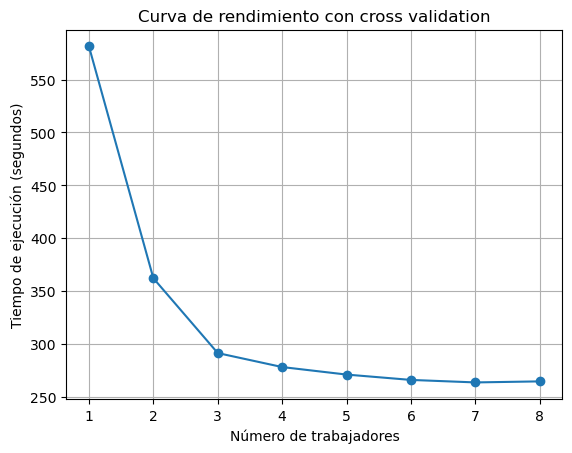

In [14]:
plt.plot(num_workers, tiempos_ejecucion_cv, marker='o')
plt.title('Curva de rendimiento con cross validation')
plt.xlabel('Número de trabajadores')
plt.ylabel('Tiempo de ejecución (segundos)')
plt.grid(True)
plt.show()

In [15]:
acceleration = []
for i in range(0, 8):
    acceleration.append(tiempos_ejecucion_cv[0]/tiempos_ejecucion_cv[i]) 

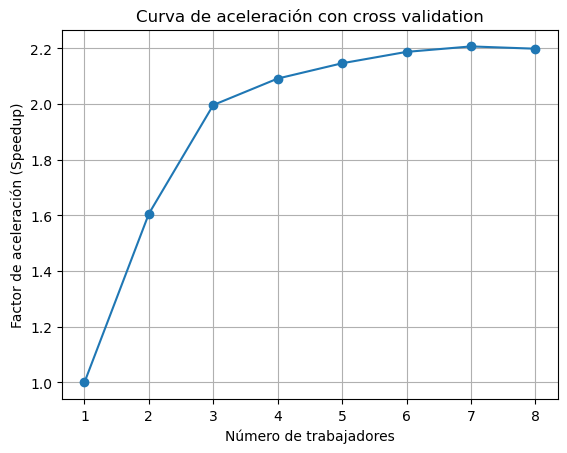

In [16]:
plt.plot(num_workers, acceleration, marker='o')
plt.title('Curva de aceleración con cross validation')
plt.xlabel('Número de trabajadores')
plt.ylabel('Factor de aceleración (Speedup)')
plt.grid(True)
plt.show()